In [43]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian, KFAC
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F
import dill
s=2
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [2]:
# data wrangling: load MNIST
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


MNIST_train = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=True,
        download=True,
        transform=MNIST_transform)


MNIST_test = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform)


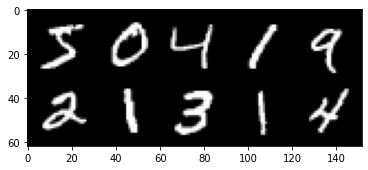

In [3]:
# have a look at the data to verify
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = MNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))


In [4]:
mnist_train_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_train,
    batch_size=128,
    shuffle=True
)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine

In [5]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)


In [6]:
#set up the training routine
mnist_model = NN(num_classes=10)
loss_function = torch.nn.CrossEntropyLoss()

mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
MNIST_PATH = "MNIST_weights_seed={}.pth".format(s)
#print(MNIST_PATH)

In [7]:
# helper function to get accuracy
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()


In [8]:
# Write the training routine and save the model at FMNIST_PATH

def train(verbose=False, num_iter=5):
    max_len = len(mnist_train_loader)
    for iter in range(num_iter):
        for batch_idx, (x, y) in enumerate(mnist_train_loader):
            output = mnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            mnist_train_optimizer.step()
            mnist_train_optimizer.zero_grad()

            if verbose:
                if batch_idx % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )

    print("saving model at: {}".format(MNIST_PATH))
    torch.save(mnist_model.state_dict(), MNIST_PATH)

In [20]:
#after training it once, comment this out to save time if you rerun the entire script
#train(verbose=True, num_iter=5)


In [9]:
#predict in distribution
MNIST_PATH = "../trained_weights/MNIST/MNIST_weights_seed={}.pth".format(s)

mnist_model = NN(num_classes=10)
print("loading model from: {}".format(MNIST_PATH))
mnist_model.load_state_dict(torch.load(MNIST_PATH))
mnist_model.eval()

#acc = []

#max_len = len(mnist_test_loader)
#for batch_idx, (x, y) in enumerate(mnist_test_loader):
#        output = mnist_model(x)
#        accuracy = get_accuracy(output, y)
#        if batch_idx % 10 == 0:
#            print(
#                "Batch {}/{} \t".format(batch_idx, max_len) + 
#                "Accuracy %.0f" % (accuracy * 100) + "%"
#            )
#        acc.append(accuracy)
#    
#avg_acc = np.mean(acc)
#print('overall test accuracy on MNIST: {:.02f} %'.format(avg_acc * 100))

loading model from: ../trained_weights/MNIST/MNIST_weights_seed=2.pth


Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=512, out_features=10, bias=True)
)

# Laplace approximation of the weights
* we use the BackPACK package to approximate the Hessian of the parameters. Especially look at the DiagHessian() method.
* we do one iteration over the entire training set and use the mean of the Hessian of the mini-batches as the best approximation of the Hessian.
* we add a prior variance to our Hessian. The precision is 1 over the variance. we use a prior precision of 10, 20, and 50 (or variance of 1/10, 1/20, 1/50).
    * edit: I will use precicisions of 10, 60, 120, 1000 in the following


In [10]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [11]:

for params in mnist_model.parameters():
    print(params.size())

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([32, 32, 5, 5])
torch.Size([32])
torch.Size([10, 512])
torch.Size([10])


# Calculate the KFAC matrices U and V (and B)

In [29]:
def get_KFAC_Hessian(model, train_loader, var0, device='cpu', batch_size=128):
    U_s = []
    V_s = []
    B_s = []
    U_invs = []
    V_invs = []
    B_invs = []
    #for params in model.parameters():
    for c in [-6, -4, -2]:    
        with backpack(KFAC()):
            M, N = list(model.parameters())[c].kfac
        
        W = list(model.parameters())[c]
        
        b = list(model.parameters())[c+1]
        
        m = M.size()[0]
        n = N.size()[0]
        
        lossfunc = torch.nn.CrossEntropyLoss()

        tau = 1/var0

        extend(lossfunc, debug=False)
        extend(model, debug=False)

        with backpack(KFAC()):
            #kronecker matrices
            U, V = torch.zeros(m, m, device=device), torch.zeros(n, n, device=device)
            #bias
            B = torch.zeros(m, m, device=device)

            #max_len = int(np.ceil(len(train_loader.dataset)/batch_size))

            for batch_idx, (x, y) in enumerate(train_loader):
                if device == 'cuda':
                    x, y = x.cuda(), y.cuda()


                model.zero_grad()
                lossfunc(model(x), y).backward()

                with torch.no_grad():
                    # Hessian of weight
                    U_, V_ = W.kfac
                    B_ = b.kfac[0]

                    U_ = np.sqrt(batch_size)*U_ + np.sqrt(tau)*torch.eye(m, device=device)
                    V_ = np.sqrt(batch_size)*V_ + np.sqrt(tau)*torch.eye(n, device=device)
                    B_ = batch_size*B_ + tau*torch.eye(m, device=device)

                    rho = min(1-1/(batch_idx+1), 0.95)

                    U = rho*U + (1-rho)*U_
                    V = rho*V + (1-rho)*V_
                    B = rho*B + (1-rho)*B_
                    
                    

            U_inv = torch.inverse(V) 
            V_inv = torch.inverse(U)
            B_inv = torch.inverse(B)
            
            U_invs.append(U_inv)
            V_invs.append(V_inv)
            B_invs.append(B_inv)
            U_s.append(U)
            V_s.append(V)
            B_s.append(B)


    return U_s, V_s, B_s, U_invs, V_invs, B_invs

In [44]:
#KFAC_prec_1 = get_KFAC_Hessian(mnist_model, mnist_train_loader, 1)
#torch.save(KFAC_prec_1, 'KFAC/KFAC_prec_1_seed_{}.pth'.format(s))
#print('saving KFAC_prec_1 ...')
#KFAC_prec_01 = get_KFAC_Hessian(mnist_model, mnist_train_loader, 10)
#torch.save(KFAC_prec_1, 'KFAC/KFAC_prec_01_seed_{}.pth'.format(s))
#print('saving KFAC_prec_01 ...')
#KFAC_prec_001 = get_KFAC_Hessian(mnist_model, mnist_train_loader, 100)
#torch.save(KFAC_prec_1, 'KFAC/KFAC_prec_001_seed_{}.pth'.format(s))
#print('saving KFAC_prec_001 ...')

#KFAC_prec_0001 = get_KFAC_Hessian(mnist_model, mnist_train_loader, 1000)
torch.save(KFAC_prec_1, 'KFAC/KFAC_prec_0001_seed_{}.pth'.format(s), pickle_module=dill)
print('saving KFAC_prec_0001 ...')
#KFAC_prec_00001 = get_KFAC_Hessian(mnist_model, mnist_train_loader, 10000)
torch.save(KFAC_prec_1, 'KFAC/KFAC_prec_00001_seed_{}.pth'.format(s), pickle_module=dill)
print('saving KFAC_prec_00001 ...')

saving KFAC_prec_0001 ...
saving KFAC_prec_00001 ...


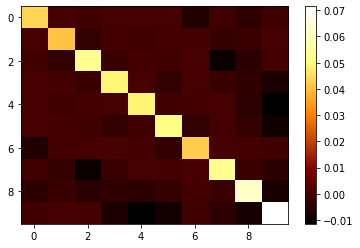

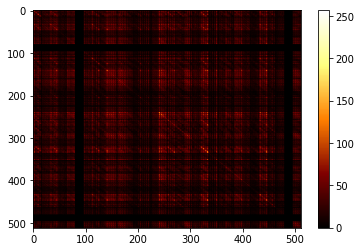

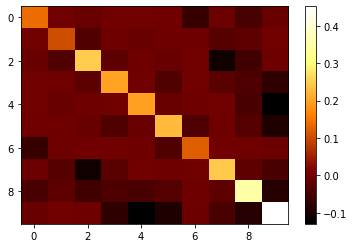

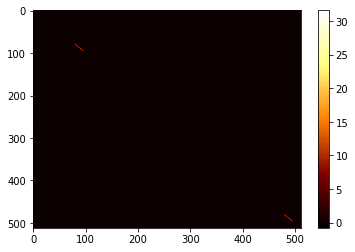

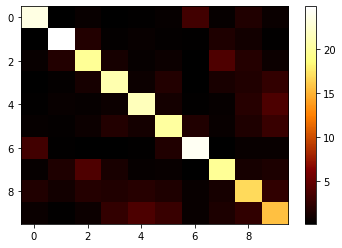

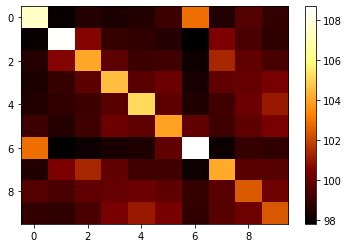

In [73]:
lyr = 2
cmap = 'afmhot'
plt.imshow(KFAC_prec_0001[0][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(KFAC_prec_0001[1][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(KFAC_prec_0001[2][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(KFAC_prec_0001[3][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(KFAC_prec_0001[4][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(KFAC_prec_0001[5][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()

In [61]:
print(len(KFAC_prec_0001[0]))

3


In [46]:
#ldKFAC_prec_1 = torch.load('KFAC/KFAC_prec_1_seed_{}.pth'.format(s))
#ldKFAC_prec_01 = torch.load('KFAC/KFAC_prec_01_seed_{}.pth'.format(s))
#ldKFAC_prec_001 = torch.load('KFAC/KFAC_prec_001_seed_{}.pth'.format(s))
ldKFAC_prec_0001 = torch.load('KFAC/KFAC_prec_0001_seed_{}.pth'.format(s))
ldKFAC_prec_00001 = torch.load('KFAC/KFAC_prec_00001_seed_{}.pth'.format(s))

In [ ]:
for i in range(6):
    plt.imshow(KFAC_prec_00001[i])
    plt.show()
    print(KFAC_prec_00001[i].size())
    #plt.imshow(ldKFAC_prec_00001[i])
    #plt.show()


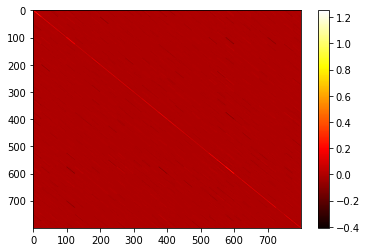

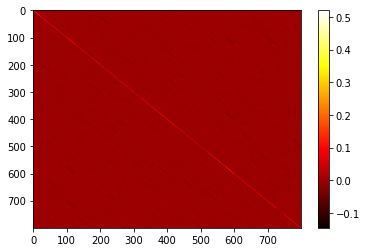

In [51]:
plt.imshow(KFAC_prec_00001[3][1],aspect='auto', cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(ldKFAC_prec_00001[3][1],aspect='auto', cmap='hot')
plt.colorbar()
plt.show()

In [48]:
print(KFAC_prec_00001[2][1])
print(ldKFAC_prec_00001[2][1])

tensor([[ 1.7173e-01, -2.5369e-02,  4.3857e-02,  ..., -1.7239e-02,
         -3.3998e-11, -2.7491e-02],
        [-2.5369e-02,  7.7908e-02,  3.1315e-02,  ..., -3.0796e-02,
          1.4849e-11, -6.0712e-02],
        [ 4.3857e-02,  3.1315e-02,  8.2180e-02,  ..., -3.8967e-02,
         -1.1373e-11, -8.8518e-02],
        ...,
        [-1.7239e-02, -3.0796e-02, -3.8967e-02,  ...,  5.5503e-02,
         -2.0781e-11,  7.9386e-02],
        [-3.3998e-11,  1.4849e-11, -1.1373e-11,  ..., -2.0781e-11,
          1.0000e-04, -1.7010e-11],
        [-2.7491e-02, -6.0712e-02, -8.8518e-02,  ...,  7.9386e-02,
         -1.7010e-11,  2.0927e-01]])
tensor([[ 1.2479e+00, -1.9974e-02,  7.4556e-02,  ..., -4.1448e-02,
          3.9807e-13, -7.2844e-02],
        [-1.9974e-02,  1.0799e+00,  3.2171e-02,  ..., -2.7830e-02,
          9.3514e-15, -7.1534e-02],
        [ 7.4556e-02,  3.2171e-02,  1.1049e+00,  ..., -4.7784e-02,
          3.3500e-14, -1.2831e-01],
        ...,
        [-4.1448e-02, -2.7830e-02, -4.7784e-02

In [ ]:
#MNIST_NN_Std_prec_1 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader)
#MNIST_NN_Std_prec_01 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.1,verbose=False)
#MNIST_NN_Std_prec_001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.01,verbose=False)
#MNIST_NN_Std_prec_0001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.001,verbose=False)
#MNIST_NN_Std_prec_00001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.0001,verbose=False)
#MNIST_NN_Std_prec_000001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.00001,verbose=False)
#torch.save(MNIST_NN_Std_prec_1, 'Hessian_prec1_seed1.pth')
#torch.save(MNIST_NN_Std_prec_01, 'Hessian_prec01_seed1.pth')
#torch.save(MNIST_NN_Std_prec_001, 'Hessian_prec001_seed1.pth')
#torch.save(MNIST_NN_Std_prec_0001, 'Hessian_prec0001_seed1.pth')
#torch.save(MNIST_NN_Std_prec_00001, 'Hessian_prec00001_seed1.pth')
#torch.save(MNIST_NN_Std_prec_000001, 'Hessian_prec000001_seed1.pth')

In [68]:
MNIST_NN_Std_prec_1 = torch.load('Hessians/MNIST/Hessian_prec1_seed{}.pth'.format(s))
MNIST_NN_Std_prec_01 = torch.load('Hessians/MNIST/Hessian_prec01_seed{}.pth'.format(s))
MNIST_NN_Std_prec_001 = torch.load('Hessians/MNIST/Hessian_prec001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_0001 = torch.load('Hessians/MNIST/Hessian_prec0001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_00001 = torch.load('Hessians/MNIST/Hessian_prec00001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_000001 = torch.load('Hessians/MNIST/Hessian_prec000001_seed{}.pth'.format(s))

## visualize the first layer of our networks in a heatmap
* therefore we put the tensor in the right form/dimensions, by concatening all of its included arrays and then reshaping the tensor


In [ ]:
#visualize(MNIST_NN_Hessian_diag_10)

In [ ]:
def meancalc(Hessian_diag_x):
    i = 0 
    for name, parameter in mnist_model.named_parameters():
        mean = torch.mean(Hessian_diag_x[i])
        print("mean standard deviation of layer {0:s}: {1:.4f}".format(name, mean.item()))
        #print(mean.item(), end =", ")
        i += 1
    


In [ ]:
#meancalc(Hessian_diag_x=MNIST_NN_Std_prec_000001)

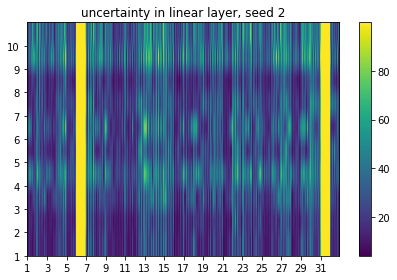

In [69]:
plt.imshow(MNIST_NN_Std_prec_00001[4], extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_yticks(np.arange(0, 1, 0.1));
ax.set_yticklabels(np.arange(1,11,1));
ax.set_title('uncertainty in linear layer, seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
plt.show()
#plt.savefig('linear_seed1000={}'.format(s))

In [ ]:
for name, parameters in mnist_model.named_parameters():
    if name == '7.weight':
        params = parameters

params_arr = params.detach().numpy()

plt.imshow(params_arr, cmap='prism',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_yticks(np.arange(0, 1, 0.1));
ax.set_yticklabels(np.arange(1,11,1));
ax.set_title('weights in linear layer, seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
im = plt.show()
#plt.hist(params_arr)

In [ ]:
def hist_feature(feature):
    to_hist = []
    target_feature = feature
    for i in range(10):
        weights = params[i].detach().numpy()
        weights = np.array_split(np.array(weights), 32)
        to_hist.append(weights[target_feature -1])
    plt.hist(to_hist)
    plt.title('weights in feature {}'.format(target_feature))

In [ ]:
hist_feature(6)

In [ ]:
print(MNIST_NN_Std_prec_00001[3][3])
print(MNIST_NN_Std_prec_00001[3][10])


In [ ]:
#for name, parameters in mnist_model.named_parameters():
 #   if name == '3.weight':
  #      params = parameters

#params_arr = params.detach().numpy()




In [ ]:
print(MNIST_NN_Std_prec_00001[2][31][31])
print(MNIST_NN_Std_prec_00001[2].size())

# visualize the second conv layer kernels


### first visualize the uncertaintys of the kernels

In [ ]:
#fig, axs = plt.subplots(4,8, figsize=(20, 15))
#fig.subplots_adjust(hspace = .001, wspace=.001)
#axs = axs.ravel()

#for i in range(32):
    #for j in range(32):
 #   axs[i].imshow(MNIST_NN_Std_prec_0001[2][i][3])

In [ ]:
from random import randint

#choose a random between 0 and 31 for 2nd dimension
j = randint(0, 31)

fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
print(j)
for i in range(32):
    #for j in range(32):
    im = axs[i].imshow(MNIST_NN_Std_prec_00001[2][i][j])
    axs[i].set_title('feature '+str(i+1))
cbar = fig.colorbar(im, ax=axs.ravel().tolist())
#interesting: s2 j24 j7

In [ ]:
def hist_feature_uncertainty(feature, j):
    to_hist_uncertainty = []
    target_feature = feature
    uncertainty = MNIST_NN_Std_prec_00001[2][target_feature -1][j].detach().numpy()
    plt.hist(uncertainty)
    plt.title('uncertainty in feature {}'.format(target_feature))
    
hist_feature_uncertainty(16, 3)

In [ ]:

#for i in range(32):
 #   print(MNIST_NN_Std_prec_00001[2][32-1][i])
    #print(MNIST_NN_Std_prec_00001[2][10][i])

### in kernels with high uncertainty the biases are maximal (100 for precision 0.0001)

In [ ]:
print(MNIST_NN_Std_prec_00001[3])

## Now viualize the weights of the kernels in the second conv layer (3.weight)

In [ ]:
for name, parameters in mnist_model.named_parameters():
    if name == '3.weight':
        params = parameters

params_arr = params.detach().numpy()
#print(params_arr[31][2])
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
#choose random number between 0 and 31 for 2nd dimension
j = randint(0, 31)
#print(j)
for i in range(32):
    #for j in range(32):
    im = axs[i].imshow(params_arr[i][11])
    axs[i].set_title('feature '+str(i+1))
cbar = fig.colorbar(im, ax=axs.ravel().tolist())



In [ ]:
#for i in range(32):
 #   print('{0:.10f}'.format(torch.mean(params[i][2]).item()))

In [ ]:
weights_mean = np.zeros(32)
for j in range(32):
    for i in range(32):
        weights_mean[i] += torch.mean(params[i][j]).item()

for i in range(32):
    print('feature {0:}: {1:.10f}'.format((i+1), weights_mean[i]))
    


### look at the biases of the 3rd layer (3.bias)

In [ ]:
for name, parameters in mnist_model.named_parameters():
    if name == '3.bias':
        params = parameters

params_arr = params.detach().numpy()
print(params_arr)
#plt.hist(params_arr)

## visualize the first conv layers kernels

### first visualize the uncertaintys of the kernels

In [ ]:
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    #for j in range(32):
    axs[i].imshow(MNIST_NN_Std_prec_0001[0][i][0])
    axs[i].set_title('feature '+str(i+1))

In [ ]:
print(MNIST_NN_Std_prec_00001[1])

## now visualize the weights of kernels in first conv layer

In [ ]:
for name, parameters in mnist_model.named_parameters():
    if name == '0.weight':
        params = parameters

params_arr = params.detach().numpy()
#print(params_arr[31][2])
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    #for j in range(32):
    axs[i].imshow(params_arr[i][0])
    axs[i].set_title('feature '+str(i+1))

In [ ]:
for name, parameters in mnist_model.named_parameters():
    if name == '0.bias':
        params = parameters

params_arr = params.detach().numpy()
print(params_arr)

## Is there a correlation between weight size and uncertainty in second conv layer?

In [ ]:
#conv2_weights = mnist_model.named_parameters
for name, parameters in mnist_model.named_parameters():
    if name == '3.weight':
        conv2_weights = parameters#.detach().numpy()
        
conv2_uncertainties = MNIST_NN_Std_prec_00001[2]

#flatten the tensors
conv2_weights_flattened = torch.flatten(conv2_weights)
conv2_uncertainties_flattened = torch.flatten(conv2_uncertainties)

In [ ]:
from scipy.stats import pearsonr

In [ ]:
#plt.scatter(conv2_weights_flattened.detach().numpy(), conv2_uncertainties_flattened.detach().numpy())
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
#print(np.cov(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy()))
corr, _ = pearsonr(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
print('Pearsons correlation: %.3f' % corr)

In [ ]:
print('we have a covariance of ')

## comparison with linear layer

In [ ]:
for name, parameters in mnist_model.named_parameters():
    if name == '7.weight':
        linear_weights = parameters
        
linear_uncertainties = MNIST_NN_Std_prec_00001[4]
linear_weights_flattened = torch.flatten(linear_weights)
linear_uncertainties_flattened = torch.flatten(linear_uncertainties)



In [ ]:

#plt.scatter(linear_weights_flattened.detach().numpy(), linear_uncertainties_flattened.detach().numpy())
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(linear_uncertainties_flattened.detach().numpy(), linear_weights_flattened.detach().numpy())
corr, _ = pearsonr(linear_uncertainties_flattened.detach().numpy(), linear_weights_flattened.detach().numpy())
print('Pearsons correlation: %.3f' % corr)

## also take a look at the first conv layer

In [ ]:
for name, parameters in mnist_model.named_parameters():
    if name == '0.weight':
        conv1_weights = parameters
        
conv1_uncertainties = MNIST_NN_Std_prec_00001[0]
conv1_weights_flattened = torch.flatten(conv1_weights)
conv1_uncertainties_flattened = torch.flatten(conv1_uncertainties)



In [ ]:
#plt.scatter(conv1_weights_flattened.detach().numpy(), conv1_uncertainties_flattened.detach().numpy())
#corr, _ = pearsonr(conv1_weights_flattened.detach().numpy(), conv1_uncertainties_flattened.detach().numpy())
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(conv1_uncertainties_flattened.detach().numpy(), conv1_weights_flattened.detach().numpy())
corr, _ = pearsonr(conv1_uncertainties_flattened.detach().numpy(), conv1_weights_flattened.detach().numpy())
print('Pearsons correlation: %.3f' % corr)

## scatterplot of weights and corresponding biases

## first conv layer

In [ ]:
#weights
for name, parameters in mnist_model.named_parameters():
    if name == '0.weight':
        conv1_weights = parameters
        
for name, parameters in mnist_model.named_parameters():
    if name == '0.bias':
        conv1_biases = parameters
        
#reshape biases
conv1_biases = torch.reshape(conv1_biases, (1, 32))

In [ ]:
#flatten weights
#conv1_weights_flattened2 = torch.flatten(conv1_weights, start_dim=1)
#print(torch.mean(conv1_weights[31]))
avgs_conv1 = []
for i in range(0,32):
    avgs_conv1.append(torch.mean(conv1_weights[i]).item())
    
plt.scatter(avgs_conv1, conv1_biases.detach().numpy())
#plt.scatter(conv1_biases.detach().numpy(), avgs_conv1)
corr, _ = pearsonr(avgs_conv1, conv1_biases.detach().numpy()[0])
print('Pearsons correlation: %.3f' % corr)


## second conv layer

In [ ]:
for name, parameters in mnist_model.named_parameters():
    if name == '3.weight':
        conv2_weights = parameters
        
for name, parameters in mnist_model.named_parameters():
    if name == '3.bias':
        conv2_biases = parameters
        
#reshape biases
#conv2_biases = torch.reshape(conv1_biases, (2, 32))

In [ ]:
#print(conv2_weights[31][31])
def avg_flatten(j):
    avgs_conv2 = []
    for i in range(0, 32):
        avgs_conv2.append(torch.mean(conv2_weights[i][j]).item())
    return avgs_conv2
    
plt.scatter(avg_flatten(3), conv2_biases.detach().numpy())
#plt.scatter(conv2_biases.detach().numpy(), avg_flatten(3))
corr, _ = pearsonr(avg_flatten(3), conv2_biases.detach().numpy())
print('Pearsons correlation: %.3f' % corr)        

In [ ]:
#for w in range(0, 32):
 #   plt.scatter(avg_flatten(w), conv2_biases.detach().numpy())

## linear layer

In [ ]:
for name, parameters in mnist_model.named_parameters():
    if name == '7.weight':
        linear_weights = parameters
        
for name, parameters in mnist_model.named_parameters():
    if name == '7.bias':
        linear_biases = parameters

In [ ]:
#print(linear_weights[1])
avgs_linear = []
for i in range(0, 10):
    avgs_linear.append(torch.mean(linear_weights[i]).item())
plt.scatter(avgs_linear, linear_biases.detach().numpy())
plt.title('linear layer: correlation between weights and biases')
corr, _ = pearsonr(avgs_linear, linear_biases.detach().numpy())
print('Pearsons correlation: %.3f' % corr) 